# Lecture 3.2: Dimensionality Reduction

[**Lecture Slides**](https://docs.google.com/presentation/d/1MERynQkNITUhDNlNsI3H_Hce-rUUuwj4vGlgObyOV64/edit?usp=sharing)

This lecture, we are going to reduce the dimensionality of a dataset using PCA.

**Learning goals:**

- Use dimensionality reduction to compress images
- Implement PCA on an emoji dataset
- Analyse the cumulative explained variance of a PCA model
- Use dimensionality reduction for data visualization

## 1. Introduction

In the lecture slides, we have seen a toy example of PCA which projected a 2D dataset down to 1D. But we have also learned that dimensionality reduction shines when applied to datasets with many dimensions. We saw how pictures were good examples, since they have as many dimensions as they have pixels.

Let's try use PCA to reduce the dimensionality of an emoji picture dataset.

## 2. Data Munging

First let's load the images using [pillow](https://pillow.readthedocs.io/en/stable/), like in lecture 2.5:

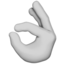

In [1]:
from PIL import Image
import glob

def open_image(path):
    return Image.open(path)

paths = glob.glob('emojis/*.png')

images = [open_image(p) for p in paths]
images[458]

The images are in grayscale to avoid having even more dimensions with three RGB channels. Speaking of which, how many pixels are there per image?

In [2]:
print(len(images))
print(images[0].size)

1067
(64, 64)


We have 1067 emojis 🎊. $64\times64$ pixels means $4096$ dimensional vectors. That's a lot! Our goal is to reduce those vectors' dimensions using PCA.

The [sklearn PCA class](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) expects data in the form of NumPy arrays, where each row is one data point, and each column is one dimension (a bit like our tabular data in lectures 2.2 & 2.3). 

Let's convert these pillow `Image`s to NumPy `ndarrays`:

In [3]:
import numpy as np

arrays = [np.asarray(im) for im in images]
arrays[0].shape

(64, 64)

Remember how images are just arrays of numbers? We have loaded our grayscale emojis into $64 \times 64$ _matrices_. But we want $4096 \times 1$ _vectors_. For this, we can use the NumPy [`.reshape()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.reshape.html) function:

In [4]:
vectors = [arr.reshape((4096,)) for arr in arrays]
vectors[0].shape

(4096,)

We have our rows, but they are "stuck" in a list. We want them to be in a large matrix! We can stack this list of vectors into one big `ndarray` with [`np.stack`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html), leaving us with a $1067 \times 4096$ matrix where each row is a vector corresponding to one emoji:

In [5]:
data = np.stack(vectors)
data.shape

(1067, 4096)

In [6]:
data[0]

array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)

## 3. Training

We are now ready to _train_ our PCA model with our `data`. sklearn makes this super easy:

In [7]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Just like k-Means (lecture 3.1), PCA is a _learning_ algorithm. Therefore, we must _train_ it, then _use_ it. But before we use our model to reduce dimensions, we can investigate the _fitting_ process by having a look at the [eigenvectors](https://web.mit.edu/be.400/www/SVD/Singular_Value_Decomposition.htm). Since we are dealing with image data, these can be visualised as follows:

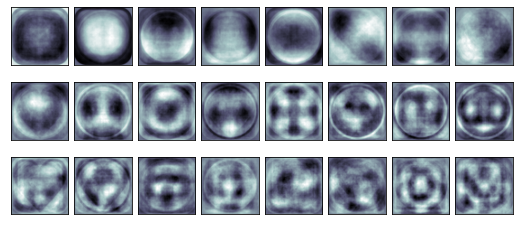

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(64, 64), cmap='bone')


Spooky images! 👻 These are representations of the optimal vector basis that our PCA model has inferred. The most "important" eigenvectors, i.e those that explain most of the data's variance, are found in the top left. Notice how the most "important" eigenvectors first focus on general lightness/darkness, then refine common orientations and patterns found in emojis.

But enough analysis, let's reduce some dimensions! And how many dimensions do we want to reduce to exactly? There is a common method to help us decide, which plots the cumulative explained variance of the eigenvectors vs the number of principal components used. This gives us a rough measure of how much information is lost in the compression. More details [here](https://stats.stackexchange.com/questions/22569/pca-and-proportion-of-variance-explained). 

Let's construct a `PCA` model with no arguments, which means that it will conserve _all_ principal components. This allows us to plot the explained proportion of variance graph:

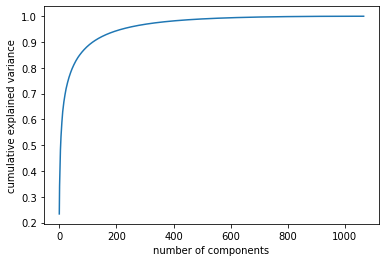

In [9]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Notice how ~ 200 components still "explains" more than 90% of the variance of the data, despite being 20 times less dimensions than the original images! Let's project our emojis down to 200 dimensions:

## 4. Dimensionality Reduction

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1000)
pca.fit(data)
components = pca.transform(data)
len(components[0])

1000

As promised, our data is reduced to 200 dimensions! However this exercise is futile if the compression destroyed too information... Luckily we are dealing with image data, so we can visually investigate:

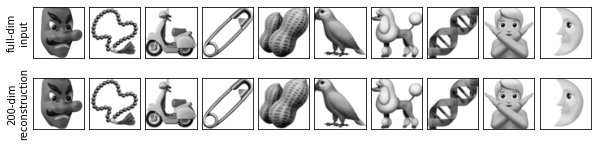

In [11]:
# inverse transform to project back to 4096 dimensions
projected = pca.inverse_transform(components)

# plot the images
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(data[i].reshape(64, 64), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(64, 64), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('200-dim\nreconstruction');

Those images got quite blurry! Notice how we can still identify the emojis despite having removed ~ 3800 dimensions. This is like deleting 95% of the columns of a large dataframe, and still having access to most of the data! 

ℹ️ Also, note that this compression was not content-aware, and had nothing to do with repetitions of pixels. This was pure mathematics using the power of singular value decomposition and eigenvector bases. Impressive! 🧙‍♂️

💪 Play around with different values of `n_components` to get a feel of how much information is lost. What's the minimum value which still allows you to recognise the Vulcan salutation?

## 5. Visualization

Earlier, we learned that dimensionality reduction can be used in data visualization to help graph high dimensional data. Our emoji dataset is _very_ high dimensional, and as we've seen in the cumulative explained variance graph, 2 dimensions won't have much explanatory power at all. Nevertheless, we can hope to see trends in a 2D graphs that might correspond to those first light vs darkness eigenvectors.

For this, we create a `.plot_components()` function to visualise emoji thumbnails on the 2D projection:

In [12]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

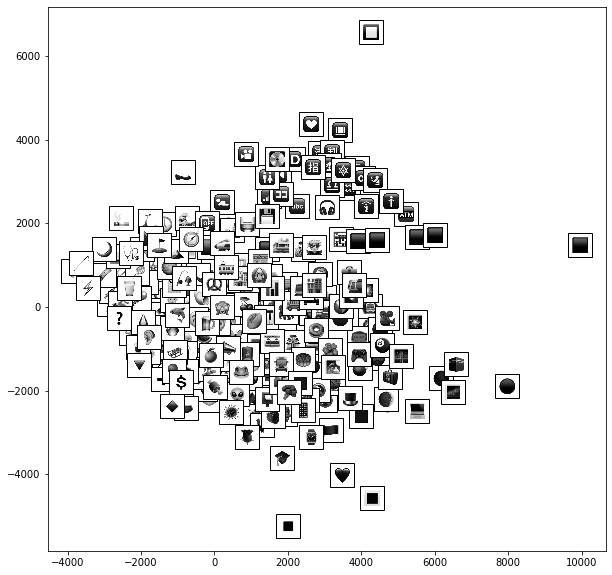

In [13]:
small_images = [im[::4, ::4] for im in arrays]
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data,
                model=PCA(n_components=2),
                images=small_images, thumb_frac=0.02)

The result is pretty good considering we just projected 4096 dimensions down to 2! Notice how the only "variations" that were conserved by PCA were light/dark, thin/large. This must be because these features explain most of the variation in the data. 

🧠🧠 Can you think of ways this could be combined with clustering (lecture 3.1) to visualize high dimensional unlabeled datasets?

## Summary

Today was our introduction to **dimensionality reduction**. We learned how methods like **PCA** can project a dataset down to **fewer dimensions**. We explained how PCA eliminates the **principal components** which least explain the data. Finally, we implemented PCA to reduce the dimensions of an emoji image dataset, which we used both for **compression**, and **data visualization**.


# Resources


### Core Resources

- [**Slides**](https://docs.google.com/presentation/d/1MERynQkNITUhDNlNsI3H_Hce-rUUuwj4vGlgObyOV64/edit?usp=sharing)
- [Python data science handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)  
Great blog post on the mechanisms and uses of PCA
- [Coursera - PCA Algorithm](https://www.coursera.org/lecture/machine-learning/principal-component-analysis-algorithm-ZYIPa)  
Excellent video from the legendary Andrew Ng, going more in depth into the mathematics of the PCA algorithm
- [Tutorial on PCA](https://arxiv.org/pdf/1404.1100.pdf)  
Comprehensive tutorial from Jonathon Shlens from Google Research, intuitive mathematical explanation of PCA

### Additional Resources

- [PCA 4 dummies](https://georgemdallas.wordpress.com/2013/10/30/principal-component-analysis-4-dummies-eigenvectors-eigenvalues-and-dimension-reduction/)  
Short but effective visualisations to explain PCA